In [1]:
import sys 
import os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
from utils import get_connection
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
con = get_connection()

connecting to rm-uf6lfxk83h7onjmwvjo.mysql.rds.aliyuncs.com3306/


In [4]:
pd.read_sql("show databases ",con)


,Database
0,douyin
1,information_schema
2,mysql
3,performance_schema
4,preprocessed_post_cls
5,preprocessed_post_cls_result
6,validation
7,xiaohongshu


In [5]:
tag_ls = pd.read_sql("SELECT distinct tag_new class_name FROM validation.tag_group_text_topic_validation" ,con)['class_name'].tolist()
tag_ls.remove('其他')
tag_ls

['旅行',
 '广告与推广',
 '美食分享与推荐',
 '烹饪与食谱',
 '健康与饮食',
 '家庭日常',
 '户外活动',
 '节日庆祝',
 '怀旧与回忆',
 '社交互动',
 '健康与养生',
 '食物评测',
 '体重管理',
 '孕期饮食与健康',
 '学习与教育',
 '儿童饮食与健康',
 '日常记录',
 '运动健身',
 '校园生活',
 '生活感悟']

In [6]:
data = pd.read_csv('data/validation_3000.csv')
print(data.shape)
data.head()

(3000, 5)


,id,content,output,text_topic,class_name
0,e04592c0da33650d9c837464dca6c706|b9393c69e2e6d...,一拖二的周六，一早起床，勿勿忙忙准备好小娃需要看病的资料，再准备我需要摆摊的工具，大娃补课催...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '日常生活挑战...",日常生活挑战,其他
1,18336dc645f26e3c3944e8c47c1c9831|d035d1c7e67d6...,津铺子的这个0卡果冻回购很多次了，一共四种口味：白桃、青提、荔枝和芒果。四个口味都还不错，口...,"{'食品类别': '蜜饯果干', '是否为零售食品': '是', '文本主题': '产品推荐...",产品推荐,广告与推广
2,b9240d65115b682962187bac31a5a14d|e64571aeb3fbf...,话梅柠檬茶！建议女孩子都把奶茶换成它！ 全网安利的咸柠茶！我能喝一整个夏天！真的好喝到原地转...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '饮品推荐',...",饮品推荐,美食分享与推荐
3,a0e6ebe573ea14303727123a5abbef3e|de754b5d37397...,随手买的香辣鱼尾也太好吃了吧！鱼肉很有嚼劲，麻麻辣辣的也太过瘾了，平时追剧或者嘴馋了来一包，...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '食品体验...",食品体验,食物评测
4,d3fc3728a8c3e13ae5988aa15e4bb0fd|320b8f65d7782...,#踏春赏花最美的景点推荐 #感受大自然的气息和美景 #旅行推荐官 #抖音带你去赏花 #春暖花...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅游推荐',...",旅游推荐,旅行


## Embedding

In [46]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# model = SentenceTransformer('BAAI/bge-small-zh-v1.5')

In [8]:
import numpy as np 
def cosine_similarity(X, Y):
    # 计算X与Y的点积
    dot_product = np.dot(X, Y.T)
    
    # 计算X和Y的范数
    X_norm = np.linalg.norm(X, axis=1, keepdims=True)
    Y_norm = np.linalg.norm(Y, axis=1)
    
    # 计算余弦相似度
    cosine_similarities = dot_product / (X_norm * Y_norm)
    
    return cosine_similarities

In [9]:
20000000/24/60/60

231.48148148148147

In [47]:
ref_ls = tag_ls
embed_model = model 
data = data 
content_col = 'content' 


tag_embed = embed_model.encode(ref_ls)
content_embed = embed_model.encode(data[content_col])


In [48]:
similarities = cosine_similarity(content_embed, tag_embed)

In [51]:
max_idx = np.argmax(similarities, axis = 1) 

max_similarity  = [(ref_ls[i], s[i]) for s,i in zip(similarities, max_idx)]

similarities_rst = [{ref:score for score, ref in zip(s, ref_ls)} for s in similarities]

data['scores'] = similarities_rst
data[['ref', 'max_score']] = max_similarity

data


,id,content,output,text_topic,class_name,scores,ref,max_score
0,e04592c0da33650d9c837464dca6c706|b9393c69e2e6d...,一拖二的周六，一早起床，勿勿忙忙准备好小娃需要看病的资料，再准备我需要摆摊的工具，大娃补课催...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '日常生活挑战...",日常生活挑战,其他,"{'旅行': 0.3433802, '广告与推广': 0.21678376, '美食分享与推...",家庭日常,0.462409
1,18336dc645f26e3c3944e8c47c1c9831|d035d1c7e67d6...,津铺子的这个0卡果冻回购很多次了，一共四种口味：白桃、青提、荔枝和芒果。四个口味都还不错，口...,"{'食品类别': '蜜饯果干', '是否为零售食品': '是', '文本主题': '产品推荐...",产品推荐,广告与推广,"{'旅行': 0.057081893, '广告与推广': 0.14571777, '美食分享...",食物评测,0.487512
2,b9240d65115b682962187bac31a5a14d|e64571aeb3fbf...,话梅柠檬茶！建议女孩子都把奶茶换成它！ 全网安利的咸柠茶！我能喝一整个夏天！真的好喝到原地转...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '饮品推荐',...",饮品推荐,美食分享与推荐,"{'旅行': 0.1663718, '广告与推广': 0.12930591, '美食分享与推...",美食分享与推荐,0.342774
3,a0e6ebe573ea14303727123a5abbef3e|de754b5d37397...,随手买的香辣鱼尾也太好吃了吧！鱼肉很有嚼劲，麻麻辣辣的也太过瘾了，平时追剧或者嘴馋了来一包，...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '食品体验...",食品体验,食物评测,"{'旅行': 0.16442816, '广告与推广': 0.23611577, '美食分享与...",烹饪与食谱,0.510388
4,d3fc3728a8c3e13ae5988aa15e4bb0fd|320b8f65d7782...,#踏春赏花最美的景点推荐 #感受大自然的气息和美景 #旅行推荐官 #抖音带你去赏花 #春暖花...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅游推荐',...",旅游推荐,旅行,"{'旅行': 0.3558244, '广告与推广': 0.19827633, '美食分享与推...",户外活动,0.493793
...,...,...,...,...,...,...,...,...
2995,594ac51b1657f4738586e8ae24552b52|2be16c8d4707b...,#好吃又便宜的网红零食推荐 发现一款超好吃的小零食，就是这款九块九三十包的酥牛排，还是盐津铺...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '零食推荐...",零食推荐,美食分享与推荐,"{'旅行': 0.060934737, '广告与推广': 0.1232169, '美食分享与...",美食分享与推荐,0.569377
2996,357b96bad7f1fa478a787ae85785d175|6298eda597a46...,救命这个燕麦酥真的不要太好吃！\n这款燕麦巧克力酥不含反式脂肪，外皮包裹巧克力\n再配上饱满...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '零食推荐',...",零食推荐,美食分享与推荐,"{'旅行': 0.081958726, '广告与推广': 0.14477742, '美食分享...",美食分享与推荐,0.511207
2997,956e86edcfd1f8201401df05c29181f3|846599ba7abdd...,尊敬的顾客朋友们\n�加一加水果零食明天4.18举行年会\n��‍♀️全体员工参加⚠️闭店一...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '商业通知',...",商业通知,其他,"{'旅行': 0.17848992, '广告与推广': 0.31520748, '美食分享与...",节日庆祝,0.485343
2998,7a6c58420d0aab1b5fc6f51a583503fe|9451fadf499ed...,#女大学生 #淄博烧烤 去淄博喽，八大局去了，紫米饼没吃，炒锅饼没吃，牛奶棒没吃，小蛋糕没吃...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅行体验',...",旅行体验,旅行,"{'旅行': 0.34284902, '广告与推广': 0.16127527, '美食分享与...",校园生活,0.444084


In [53]:
data.to_csv('data/paraphrase-multilingual-MiniLM-L12-v2-3000.csv', index = False)

In [52]:
data_ = data.query("class_name != '其他'")

[FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/AssetsV2/com_apple_MobileAsset_Font7/eb257c12d1a51c8c661b89f30eec56cacf9b8987.asset/AssetData/STHEITI.ttf', name='STHeiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/AssetsV2/com_apple_MobileAsset_Font7/f0706a236683628e16427c6569e441423faaaa93.asset/AssetData/STXIHEI.ttf', name='STHeiti', style='normal', variant='normal', weight=300, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/Fonts/STHeiti Light.ttc', name='Heiti TC', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')]


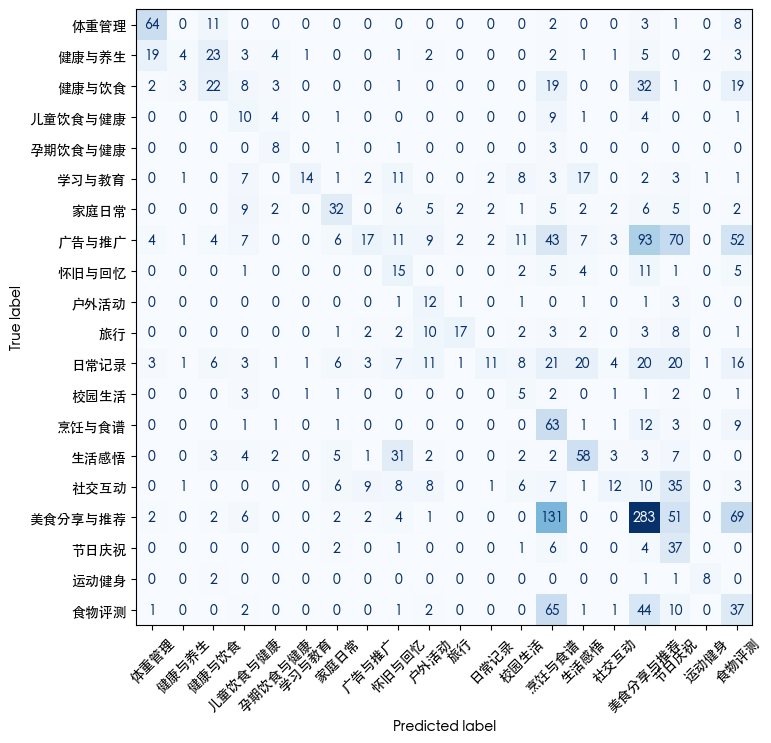

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib
print([f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name])

matplotlib.rcParams['font.family'] = ['Heiti TC']

data['class_name'].unique()

import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize = (8,8))


ConfusionMatrixDisplay.from_predictions(data_['class_name'],data_['ref'], ax = ax, cmap= 'Blues', colorbar=False)
ax.tick_params(axis='x', labelrotation=45)


In [133]:
target_col = 'class_name'

X = content_embed
y = data[target_col]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


In [134]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(class_weight = 'balanced',alpha = 10)

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
pred_test = clf.predict(X_test)



0.4928571428571429


In [135]:
print(clf.score(X_test, y_test))

0.39444444444444443


In [136]:
(pred_test == y_test)[y_test!='其他'].mean()

0.4785185185185185

In [140]:
y.unique().__len__()

21

In [145]:
input_len = content_embed.shape[1]
input_len

384

tensor([[ 1.7376e-01, -1.2176e-01,  5.5393e-02,  ..., -4.2385e-02,
         -1.1467e-01,  1.3275e-02],
        [ 1.0672e-01,  1.5059e-03,  1.8054e-01,  ...,  1.8122e-01,
         -1.2767e-01, -5.9774e-02],
        [ 1.6631e-01, -8.5340e-02,  8.9104e-02,  ...,  1.6619e-02,
         -4.3904e-03,  2.8279e-02],
        ...,
        [-6.9809e-03, -3.8793e-02,  2.5448e-01,  ...,  8.1355e-02,
          1.0153e-01,  7.2155e-02],
        [-4.7797e-03,  7.0479e-02,  8.7446e-02,  ..., -4.4032e-02,
          5.3492e-02,  9.2040e-02],
        [ 1.1030e-01, -2.0418e-01, -8.3830e-06,  ...,  1.3996e-01,
          2.7303e-01, -2.7303e-02]])

In [162]:
y_train

1826    美食分享与推荐
629     美食分享与推荐
2113    美食分享与推荐
1376       体重管理
202        社交互动
         ...   
1537       体重管理
2093       日常记录
1284       节日庆祝
1546         其他
2582    美食分享与推荐
Name: class_name, Length: 2100, dtype: object

y_train

In [179]:
from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder(sparse_output=False)

y_train_encoded = label_encoder.fit_transform(y_train.values.reshape(-1, 1))


In [ ]:
data

In [255]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model, layers

model = Sequential(
    [   
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(.5),
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(.5),
        # layers.LayerNormalization(),
        layers.Dense(21, activation = 'softmax')
    ]
)

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(1e-2,.8), metrics = ['accuracy'])


model.fit(
    X_train, y_train_encoded, batch_size = 32, epochs = 1000, validation_data = (X_test, label_encoder.transform(y_test.values.reshape(-1,1)))
)

Epoch 1/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1438 - loss: 2.9257 - val_accuracy: 0.2633 - val_loss: 2.5063
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.2858 - loss: 2.5302 - val_accuracy: 0.3367 - val_loss: 2.3859
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3201 - loss: 2.4111 - val_accuracy: 0.3656 - val_loss: 2.3115
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3477 - loss: 2.3585 - val_accuracy: 0.3622 - val_loss: 2.2374
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3488 - loss: 2.2841 - val_accuracy: 0.3689 - val_loss: 2.1986
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.3730 - loss: 2.2190 - val_accuracy: 0.3700 - val_loss: 2.1471
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.3476 - loss: 2.2324 - val_accuracy: 0.3700 - val_loss: 2.0996
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3828 - loss: 2.1205 - val_accura

In [228]:
model.fit.__doc__()

TypeError: 'NoneType' object is not callable

In [180]:
y_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [181]:
data

,id,content,output,text_topic,class_name,scores,ref,max_score
0,e04592c0da33650d9c837464dca6c706|b9393c69e2e6d...,一拖二的周六，一早起床，勿勿忙忙准备好小娃需要看病的资料，再准备我需要摆摊的工具，大娃补课催...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '日常生活挑战...",日常生活挑战,其他,"{'旅行': 0.3433802, '广告与推广': 0.21678376, '美食分享与推...",家庭日常,0.462409
1,18336dc645f26e3c3944e8c47c1c9831|d035d1c7e67d6...,津铺子的这个0卡果冻回购很多次了，一共四种口味：白桃、青提、荔枝和芒果。四个口味都还不错，口...,"{'食品类别': '蜜饯果干', '是否为零售食品': '是', '文本主题': '产品推荐...",产品推荐,广告与推广,"{'旅行': 0.057081893, '广告与推广': 0.14571777, '美食分享...",食物评测,0.487512
2,b9240d65115b682962187bac31a5a14d|e64571aeb3fbf...,话梅柠檬茶！建议女孩子都把奶茶换成它！ 全网安利的咸柠茶！我能喝一整个夏天！真的好喝到原地转...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '饮品推荐',...",饮品推荐,美食分享与推荐,"{'旅行': 0.1663718, '广告与推广': 0.12930591, '美食分享与推...",美食分享与推荐,0.342774
3,a0e6ebe573ea14303727123a5abbef3e|de754b5d37397...,随手买的香辣鱼尾也太好吃了吧！鱼肉很有嚼劲，麻麻辣辣的也太过瘾了，平时追剧或者嘴馋了来一包，...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '食品体验...",食品体验,食物评测,"{'旅行': 0.16442816, '广告与推广': 0.23611577, '美食分享与...",烹饪与食谱,0.510388
4,d3fc3728a8c3e13ae5988aa15e4bb0fd|320b8f65d7782...,#踏春赏花最美的景点推荐 #感受大自然的气息和美景 #旅行推荐官 #抖音带你去赏花 #春暖花...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅游推荐',...",旅游推荐,旅行,"{'旅行': 0.3558244, '广告与推广': 0.19827633, '美食分享与推...",户外活动,0.493793
...,...,...,...,...,...,...,...,...
2995,594ac51b1657f4738586e8ae24552b52|2be16c8d4707b...,#好吃又便宜的网红零食推荐 发现一款超好吃的小零食，就是这款九块九三十包的酥牛排，还是盐津铺...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '零食推荐...",零食推荐,美食分享与推荐,"{'旅行': 0.060934737, '广告与推广': 0.1232169, '美食分享与...",美食分享与推荐,0.569377
2996,357b96bad7f1fa478a787ae85785d175|6298eda597a46...,救命这个燕麦酥真的不要太好吃！\n这款燕麦巧克力酥不含反式脂肪，外皮包裹巧克力\n再配上饱满...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '零食推荐',...",零食推荐,美食分享与推荐,"{'旅行': 0.081958726, '广告与推广': 0.14477742, '美食分享...",美食分享与推荐,0.511207
2997,956e86edcfd1f8201401df05c29181f3|846599ba7abdd...,尊敬的顾客朋友们\n�加一加水果零食明天4.18举行年会\n��‍♀️全体员工参加⚠️闭店一...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '商业通知',...",商业通知,其他,"{'旅行': 0.17848992, '广告与推广': 0.31520748, '美食分享与...",节日庆祝,0.485343
2998,7a6c58420d0aab1b5fc6f51a583503fe|9451fadf499ed...,#女大学生 #淄博烧烤 去淄博喽，八大局去了，紫米饼没吃，炒锅饼没吃，牛奶棒没吃，小蛋糕没吃...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅行体验',...",旅行体验,旅行,"{'旅行': 0.34284902, '广告与推广': 0.16127527, '美食分享与...",校园生活,0.444084


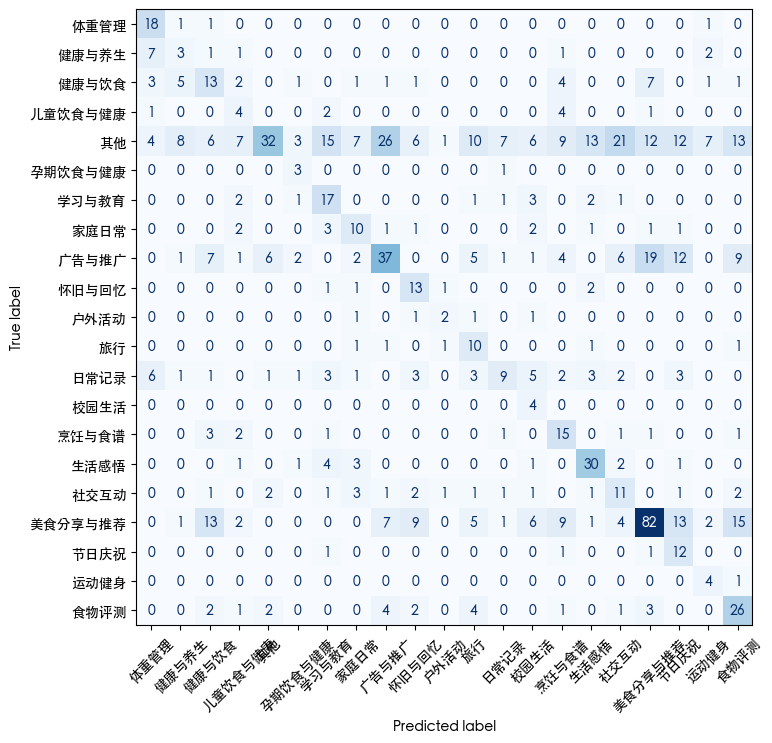

In [137]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay.from_predictions(y_test,pred_test, ax = ax, cmap= 'Blues', colorbar=False)
ax.tick_params(axis='x', labelrotation=45)

In [65]:
data_.shape

(3001, 5)

In [66]:
data

,id,content,output,text_topic,class_name
0,e04592c0da33650d9c837464dca6c706|b9393c69e2e6d...,一拖二的周六，一早起床，勿勿忙忙准备好小娃需要看病的资料，再准备我需要摆摊的工具，大娃补课催...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '日常生活挑战...",日常生活挑战,其他
1,18336dc645f26e3c3944e8c47c1c9831|d035d1c7e67d6...,津铺子的这个0卡果冻回购很多次了，一共四种口味：白桃、青提、荔枝和芒果。四个口味都还不错，口...,"{'食品类别': '蜜饯果干', '是否为零售食品': '是', '文本主题': '产品推荐...",产品推荐,广告与推广
2,b9240d65115b682962187bac31a5a14d|e64571aeb3fbf...,话梅柠檬茶！建议女孩子都把奶茶换成它！ 全网安利的咸柠茶！我能喝一整个夏天！真的好喝到原地转...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '饮品推荐',...",饮品推荐,美食分享与推荐
3,a0e6ebe573ea14303727123a5abbef3e|de754b5d37397...,随手买的香辣鱼尾也太好吃了吧！鱼肉很有嚼劲，麻麻辣辣的也太过瘾了，平时追剧或者嘴馋了来一包，...,"{'食品类别': '肉脯卤味', '是否为零售食品': '是', '文本主题': '食品体验...",食品体验,食物评测
4,d3fc3728a8c3e13ae5988aa15e4bb0fd|320b8f65d7782...,#踏春赏花最美的景点推荐 #感受大自然的气息和美景 #旅行推荐官 #抖音带你去赏花 #春暖花...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅游推荐',...",旅游推荐,旅行
...,...,...,...,...,...
2996,357b96bad7f1fa478a787ae85785d175|6298eda597a46...,救命这个燕麦酥真的不要太好吃！\n这款燕麦巧克力酥不含反式脂肪，外皮包裹巧克力\n再配上饱满...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '零食推荐',...",零食推荐,美食分享与推荐
2997,956e86edcfd1f8201401df05c29181f3|846599ba7abdd...,尊敬的顾客朋友们\n�加一加水果零食明天4.18举行年会\n��‍♀️全体员工参加⚠️闭店一...,"{'食品类别': '未知', '是否为零售食品': '是', '文本主题': '商业通知',...",商业通知,其他
2998,7a6c58420d0aab1b5fc6f51a583503fe|9451fadf499ed...,#女大学生 #淄博烧烤 去淄博喽，八大局去了，紫米饼没吃，炒锅饼没吃，牛奶棒没吃，小蛋糕没吃...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '旅行体验',...",旅行体验,旅行
2999,074f6dadd9c367d16d5b9630fb762e99|22c45af3df79d...,今年的第一颗荔枝王。#抖音伙伴计划 哇塞，怎么会有比我手掌还大的荔枝呀。真是超大超满足啊，果...,"{'食品类别': '未知', '是否为零售食品': '否', '文本主题': '季节性食品体...",季节性食品体验,其他


In [102]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np


# x_tsne = TSNE(n_components=2, learning_rate=1e-1,init='random', perplexity=10, random_state=42).fit_transform(content_embed)

def _processing_text(x, width = 20):
    w = 0
    rst = ''
    for i in x:
        w += 1 
        rst += i 
        if w == width:
            rst += '<br>'
            w = 0
    return rst
            

data_ = data.copy()

data_['tsne1'] = x_tsne[:,0]
data_['tsne2'] = x_tsne[:,1]

data_['content'] = data_['content'].replace('\n', '<br>')
data_['content'] = data_['content'].apply(_processing_text)
color_ls = px.colors.qualitative.Alphabet

class_name_ls = tag_ls

color_dict = {t:c  for t, c in zip(class_name_ls,color_ls)}


fig = px.scatter(data_, x="tsne1", y="tsne2", color='class_name',hover_name= 'class_name', hover_data='content',custom_data=['content','class_name'])
fig.update_traces(hovertemplate='%{customdata[1]}<br>%{customdata[0]}')
fig.update_layout(template = 'simple_white', width = 1000, height = 700)
fig.update_xaxes(mirror = True)
fig.update_yaxes(mirror = True)

In [103]:
fig.write_html('data/sentence-transformers-paraphrase-multilingual-MiniLM-L12-v2.html')